# Analysis of world development indicators for the prediction of income levels or geographic regions at a country-level

Link for the data : https://drive.google.com/drive/folders/1fNsdCaBysj0E-sTvE0IhGVidTTwJoLaj?usp=sharing

Put 'data' and 'finalData.pkl' at the root folder of the zip.

In [2]:
%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import time
import pickle
import wbdata
import warnings
from pygsp import graphs, filters, plotting
from sklearn import preprocessing, decomposition
from mpl_toolkits.mplot3d import Axes3D
import IPython.display as ipd
from collections import defaultdict

from Modules.data_acquisition import get_data, data_format
from Modules.utils import *
from Modules.plots import *

warnings.filterwarnings('ignore')

# I. Introduction

The idea of the project was to use data from the World Bank to analyze which set of indicators were better at predicting to which group belonged each country. 

The _World Development Indicators_ are a set of global development indicators collected by the World Bank, at a country-, region- and global-level. They span multiple themes such as health, education, demographics, economy,... and are collected on a yearly basis, starting from 1960.
Furthermore, the countries are classified according to the World Bank classification, namely by 'geographic region' or  'income level', plus another custom-made label about 'migration rate'. 

Thanks to these labels, we wanted to analyze which indicators (grouped in thematic groups) were better at clustering our countries.

At first, a dataset about health, nutrition and population statistics (__[link](https://www.kaggle.com/theworldbank/health-nutrition-and-population-statistics)__) was downloaded from Kaggle, but it was further enriched with many more indicators scrapped from the World Bank, as we wanted to get a comprehensive list of possible indicators that would not only span health, nutrition and demographics but many other themes such as education, poverty, or economy.

# I. Data acquisition

As said before, we started with the initial Kaggle dataset

In [3]:
#Initial dataset
df = pd.read_csv('./data/data.csv',  index_col=0)
# Code to indicator name
code_to_indicator = dict(zip(df['Indicator Code'],df['Indicator Name']))
code_to_country = dict(zip(df['Country Code'],df.index))
country_to_code = {v: k for k, v in code_to_country.items()}

#Transform the dataframe in multicolumns format
df = df.set_index('Country Code')
df.drop(labels=['Indicator Name'],axis=1, inplace=True)
df.set_index([df.index,'Indicator Code'],inplace=True)
df = df.unstack(level=-1)
print('Data consists of {} countries with {} indicators across {} years'.format(len(df.index),len(set(df.columns.get_level_values(1))),len(set(df.columns.get_level_values(0)))))
print('\nExample indicator code: NY.GNP.PCAP.CD -> {}'.format(code_to_indicator['NY.GNP.PCAP.CD']))
print('Example country code dict: AGO -> {}'.format(code_to_country['AGO']))
df.head(5)

Data consists of 258 countries with 345 indicators across 57 years

Example indicator code: NY.GNP.PCAP.CD -> GNI per capita, Atlas method (current US$)
Example country code dict: AGO -> Angola


1960                                            \
Indicator Code NY.GNP.PCAP.CD SE.ADT.1524.LT.FM.ZS SE.ADT.1524.LT.MA.ZS   
Country Code                                                              
ABW                       NaN                  NaN                  NaN   
ADO                       NaN                  NaN                  NaN   
AFG                       NaN                  NaN                  NaN   
AGO                       NaN                  NaN                  NaN   
ALB                       NaN                  NaN                  NaN   

                                                                      \
Indicator Code SE.ADT.1524.LT.ZS SE.ADT.LITR.FE.ZS SE.ADT.LITR.MA.ZS   
Country Code                                                           
ABW                          NaN               NaN               NaN   
ADO                          NaN               NaN               NaN   
AFG                          NaN               NaN               NaN   
AGO                          NaN               NaN               NaN   
ALB                          NaN               NaN               NaN   

                                                                               \
Indicator Code SE.ADT.LITR.ZS SE.ENR.ORPH SE.PRM.CMPT.FE.ZS SE.PRM.CMPT.MA.ZS   
Country Code                                                                    
ABW                       NaN         NaN               NaN               NaN   
ADO                       NaN         NaN               NaN               NaN   
AFG                       NaN         NaN               NaN               NaN   
AGO                       NaN         NaN               NaN               NaN   
ALB                       NaN         NaN               NaN               NaN   

                   ...           Unnamed: 60                                \
Indicator Code     ...     SP.REG.BRTH.UR.ZS SP.REG.BRTH.ZS SP.REG.DTHS.ZS   
Country Code       ...                                                       
ABW                ...                   NaN            NaN            NaN   
ADO                ...                   NaN            NaN            NaN   
AFG                ...                   NaN            NaN            NaN   
AGO                ...                   NaN            NaN            NaN   
ALB                ...                   NaN            NaN            NaN   

                                                                      \
Indicator Code SP.RUR.TOTL SP.RUR.TOTL.ZG SP.RUR.TOTL.ZS SP.URB.GROW   
Country Code                                                           
ABW                    NaN            NaN            NaN         NaN   
ADO                    NaN            NaN            NaN         NaN   
AFG                    NaN            NaN            NaN         NaN   
AGO                    NaN            NaN            NaN         NaN   
ALB                    NaN            NaN            NaN         NaN   

                                                          
Indicator Code SP.URB.TOTL SP.URB.TOTL.IN.ZS SP.UWT.TFRT  
Country Code                                              
ABW                    NaN               NaN         NaN  
ADO                    NaN               NaN         NaN  
AFG                    NaN               NaN         NaN  
AGO                    NaN               NaN         NaN  
ALB                    NaN               NaN         NaN  

[5 rows x 19665 columns]

This dataset only contained data about health, nutrition and demographics. We wanted to increase the amount of indicators available, to increase the chances of finding something of interest.
As such all the possible indicators were queried from the World Bank and converted into a dataframe. A few functions from the module **wbdata** were used to query all the indicators available in the different databases of the world bank.

In [ ]:
"""/!\ Execution of this cell takes a very long time (>24hrs)"""
# GET ALL POSSIBLE INDICATORS WITHOUT THE ONES WE ALREADY HAVE
all_indicators = wbdata.get_indicator(display=False)
all_indicators = set([d['id'] for d in all_indicators])
all_indicators = list(all_indicators - set(code_to_indicator.keys()))
how_many_chunks = 5
get_data(code_to_indicator=code_to_indicator, how_many_chunks=how_many_chunks, all_indicators=all_indicators)

# Construct final dataframe
finalDF = pd.DataFrame()
for i in range(0,how_many_chunks):
    temp = pd.read_pickle('./data/data{}.pkl'.format(i),compression='gzip')
    with open('./data/dict{}.pickle'.format(i), 'rb') as handle:
        temp_dict = pickle.load(handle)
    df = data_format(temp,country_to_code) # format data into nice dataframe similar as what is abouve
    finalDF = pd.concat([finalDF,df],axis=1)
    code_to_indicator.update(temp_dict)
finalDF.to_pickle('./finalData.pkl',compression='gzip') # save final data
with open('./code_to_country_dict.pickle', 'wb') as handle:
            pickle.dump(code_to_country, handle, protocol=pickle.HIGHEST_PROTOCOL) # save code to country dict
with open('./code_to_indicator_dict.pickle', 'wb') as handle:
            pickle.dump(code_to_indicator, handle, protocol=pickle.HIGHEST_PROTOCOL) # save code to indicator dict

Once all the data was saved, a unique dataset was generated and was the one we worked with for the end of the report.

In [4]:
data = pd.read_pickle('./finalData.pkl', compression='gzip')
# clean the raw data. Basically removed not 'weird' years and remove countries that are aggregates, such as WLD = world, OED = OECD countries, etc.
data = first_clean(data)

# load dictionnaries. 
code_to_country = pickle.load(open('./code_to_country_dict.pickle','rb')) # ISO3 code to name of the country. EX code_to_country['BRA'] = Brazil
code_to_indicator = pickle.load(open('./code_to_indicator_dict.pickle','rb')) # Indicator code to name of the indicator. EX code_to_indicator['SP.POP.TOTL'] = Population, total 

# Build indicators, years, and countries lists
indicators = list(set(data.columns.levels[1]))
years = list(set(data.columns.levels[0][:-1]))
countries = list(set(data.index))
print('Data consists of {} countries with {} indicators across {} years'.format(len(countries),len(indicators),len(years)))

# Get labels, code_to_labels and colors
# labels = labels of each country, specified with 'method' 
# code_to_labels = dict of ISO3 country code to label. EX code_to_labels['BRA'] = 1
# colors = dict of ISO3 country code to label color. EX colors['BRA'] = 'b'

labels,code_to_labels,colors = get_labels(countries) #by income level
#labels,code_to_labels,colors = get_labels(countries,method='migration',df=data.xs('SM.POP.NETM',level=1,axis=1)) #by migration rate
#labels,code_to_labels,colors = get_labels(countries,method='region') #by region

Data consists of 221 countries with 8266 indicators across 56 years


The countries can be labeled according to three categories: region, income level and migration rate (positive or negative)

In [5]:
print('By region:')
print(get_labels(countries,method='region')[1])
print('\nBy income level:')
print(get_labels(countries,method='incomeLevel')[1])
print('\nBy migration rate:')
print(get_labels(countries,method='migration',df=data.xs('SM.POP.NETM',level=1,axis=1))[1])

By region:
{'LCN': 'Latin America & Caribbean ', 'SAS': 'South Asia', 'SSF': 'Sub-Saharan Africa ', 'ECS': 'Europe & Central Asia', 'MEA': 'Middle East & North Africa', 'EAS': 'East Asia & Pacific', 'NAC': 'North America', 'NA': 'Aggregates'}

By income level:
{'HIC': 'High income', 'LIC': 'Low income', 'LMC': 'Lower middle income', 'UMC': 'Upper middle income', 'NA': 'Aggregates'}

By migration rate:
{1: 'positive', -1: 'negative', 0: 'none'}


# II. Data Exploration

#### In this part, a first exploration of the data was made. We wanted to check how much data was actually available

<IPython.core.display.Javascript object>


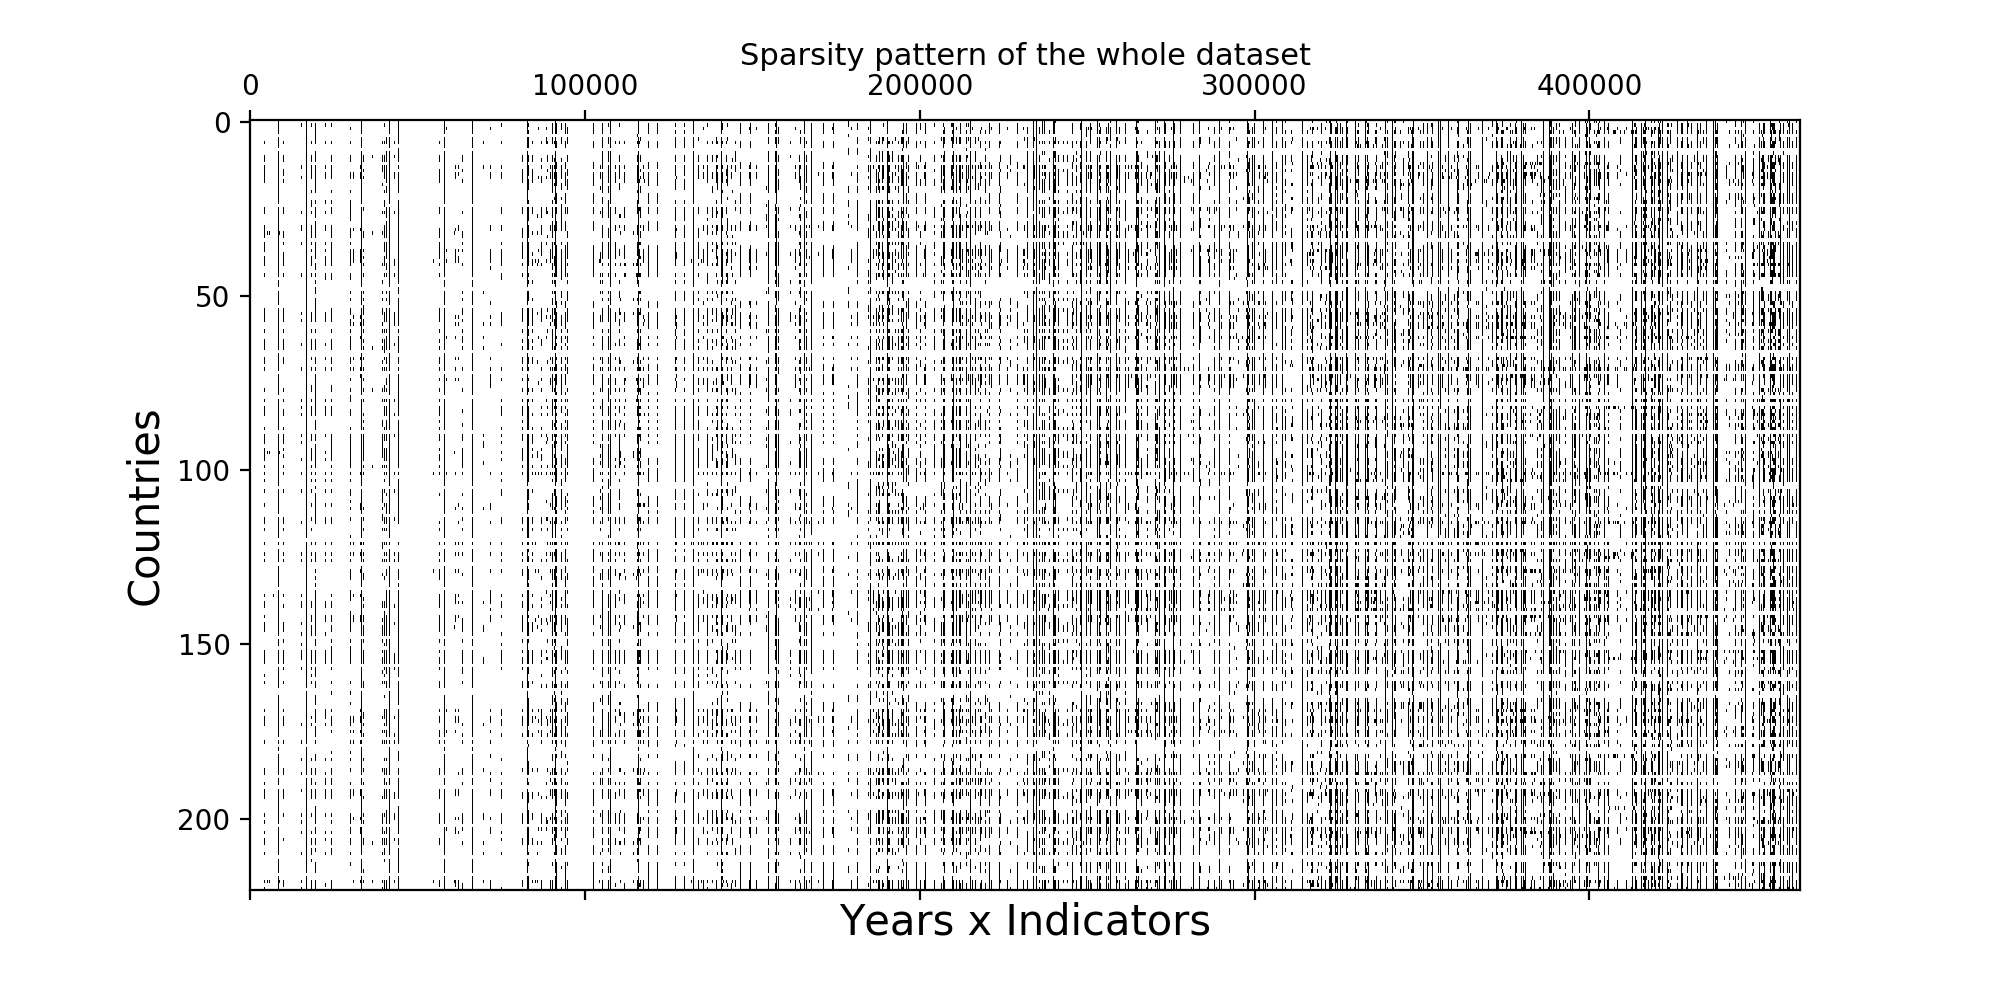

<IPython.core.display.Javascript object>


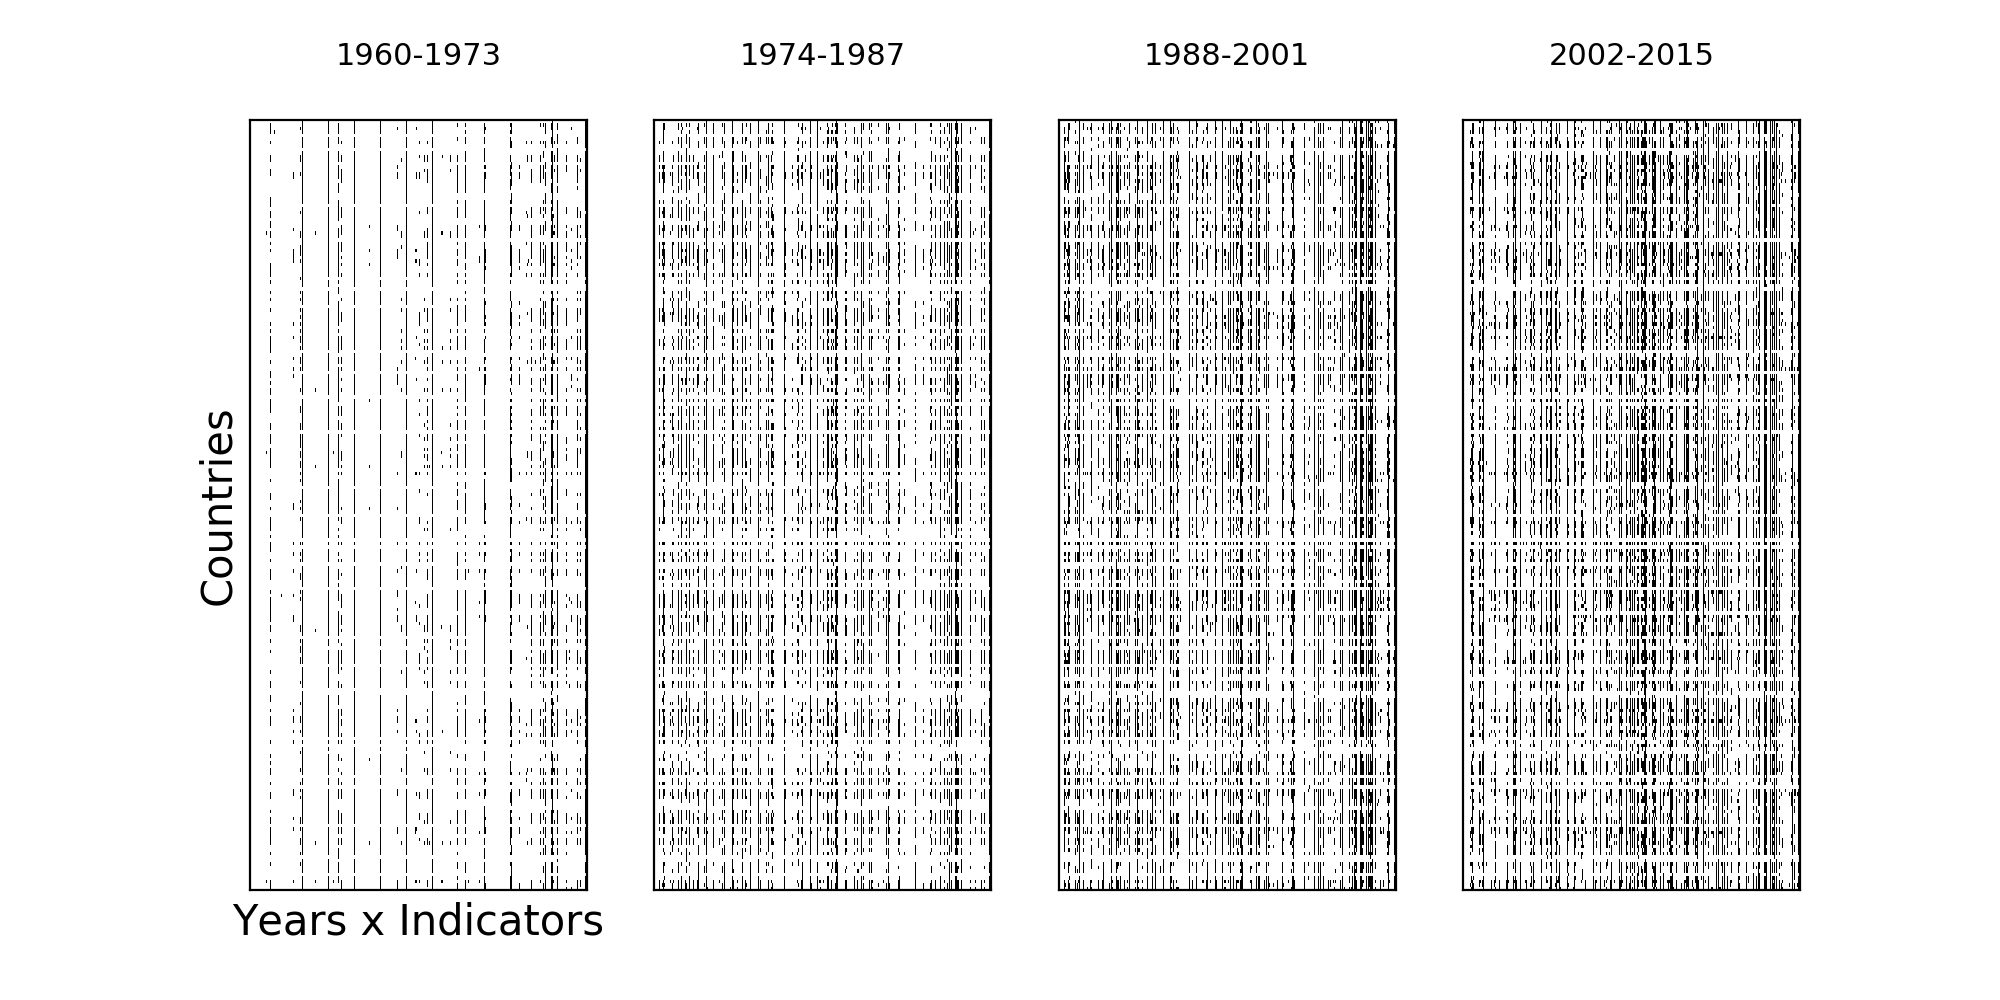

In [6]:
# PLOT SPARSITY PATTERN OF THE WHOLE DATASET
plotSparsityFull(data)

# PLOT SPARSITY PATTERN OF year-ranges
plotSparsityRange(data,4)

Raw dataset has 88114297 NaN values (86.13%)



<IPython.core.display.Javascript object>


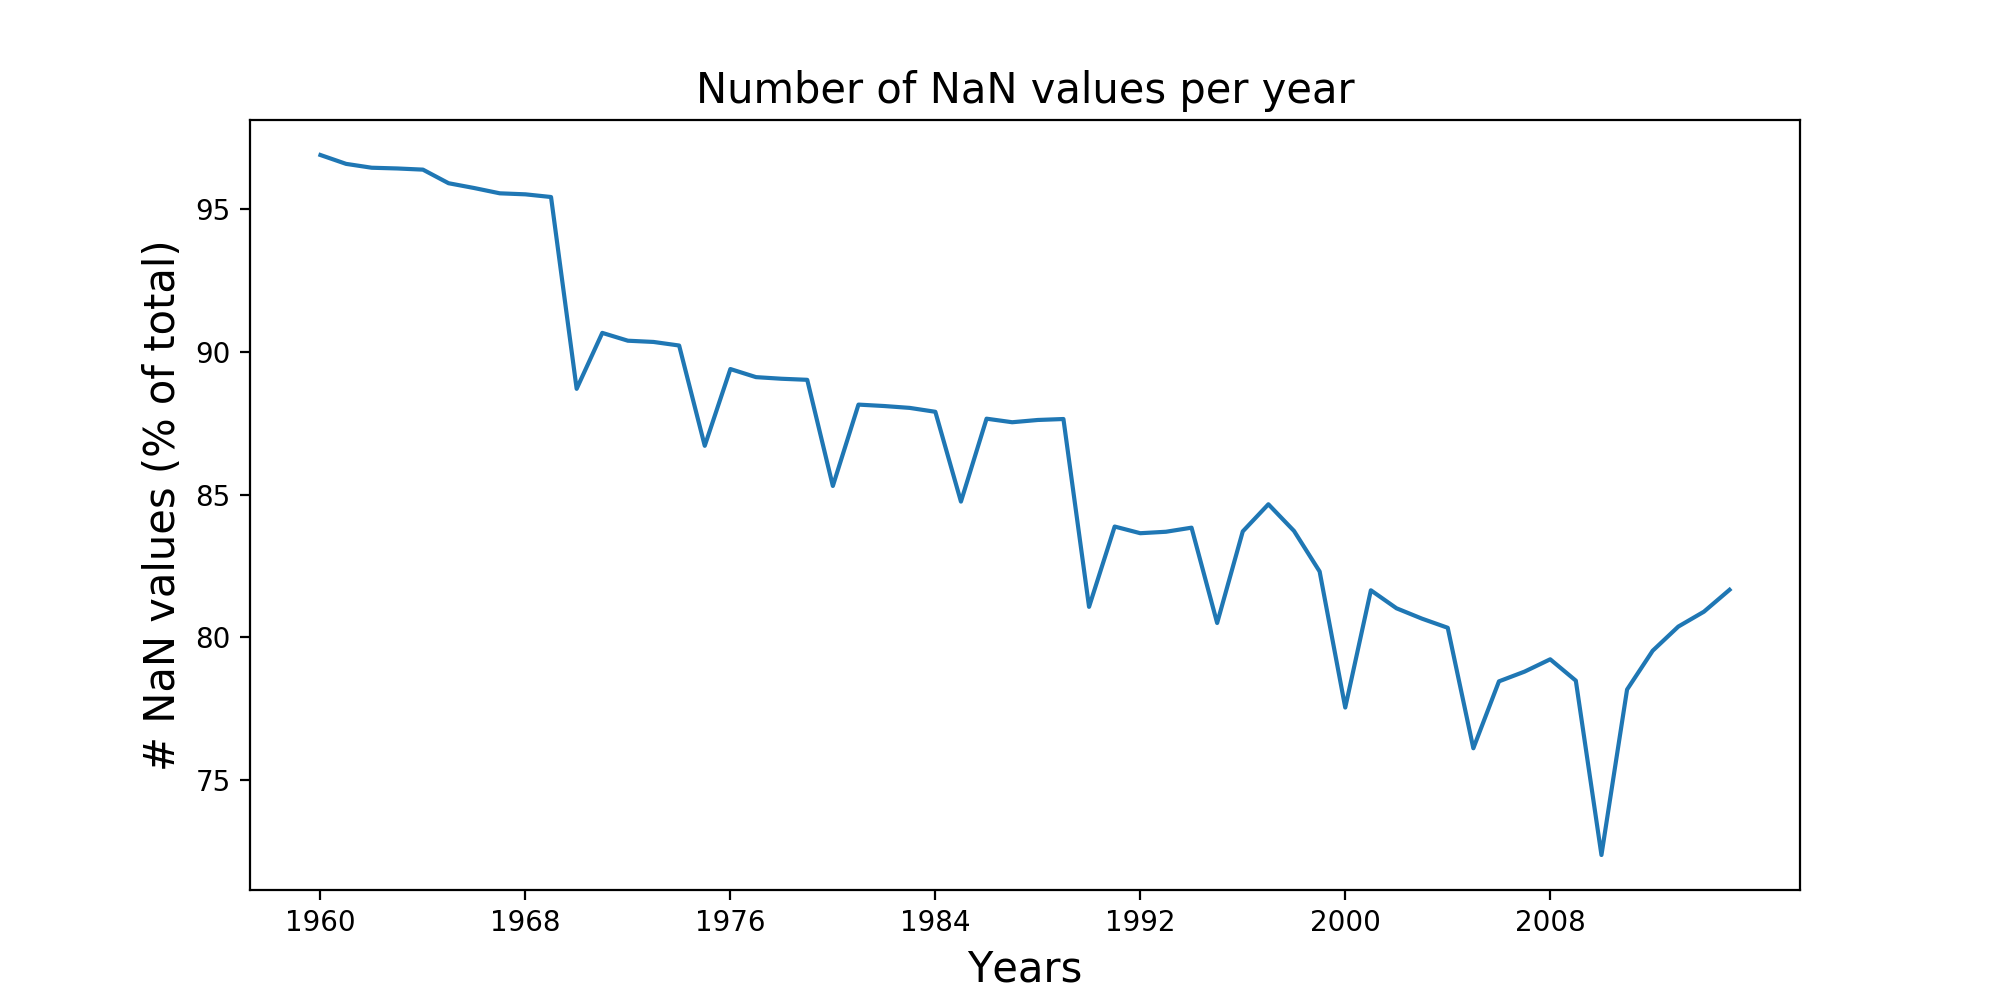

In [7]:
# How many NaN values in whole dataset
how_many_nans = data.isnull().sum().sum()
print('Raw dataset has {0} NaN values ({1:.2f}%)\n'.format(how_many_nans,100*(how_many_nans/data.size)))

# PLOT NUMBER OF NANS PER YEAR
plotNANperyear(data)

As we have seen in the above 3 plots, our data matrix is mostly empty. Futhermore, data increases when we get to more recent years. 

Another interesting behavior is that we constantly have more data in 5 years intervals. This makes sense as many indicators were probably not sampled every year.

<IPython.core.display.Javascript object>


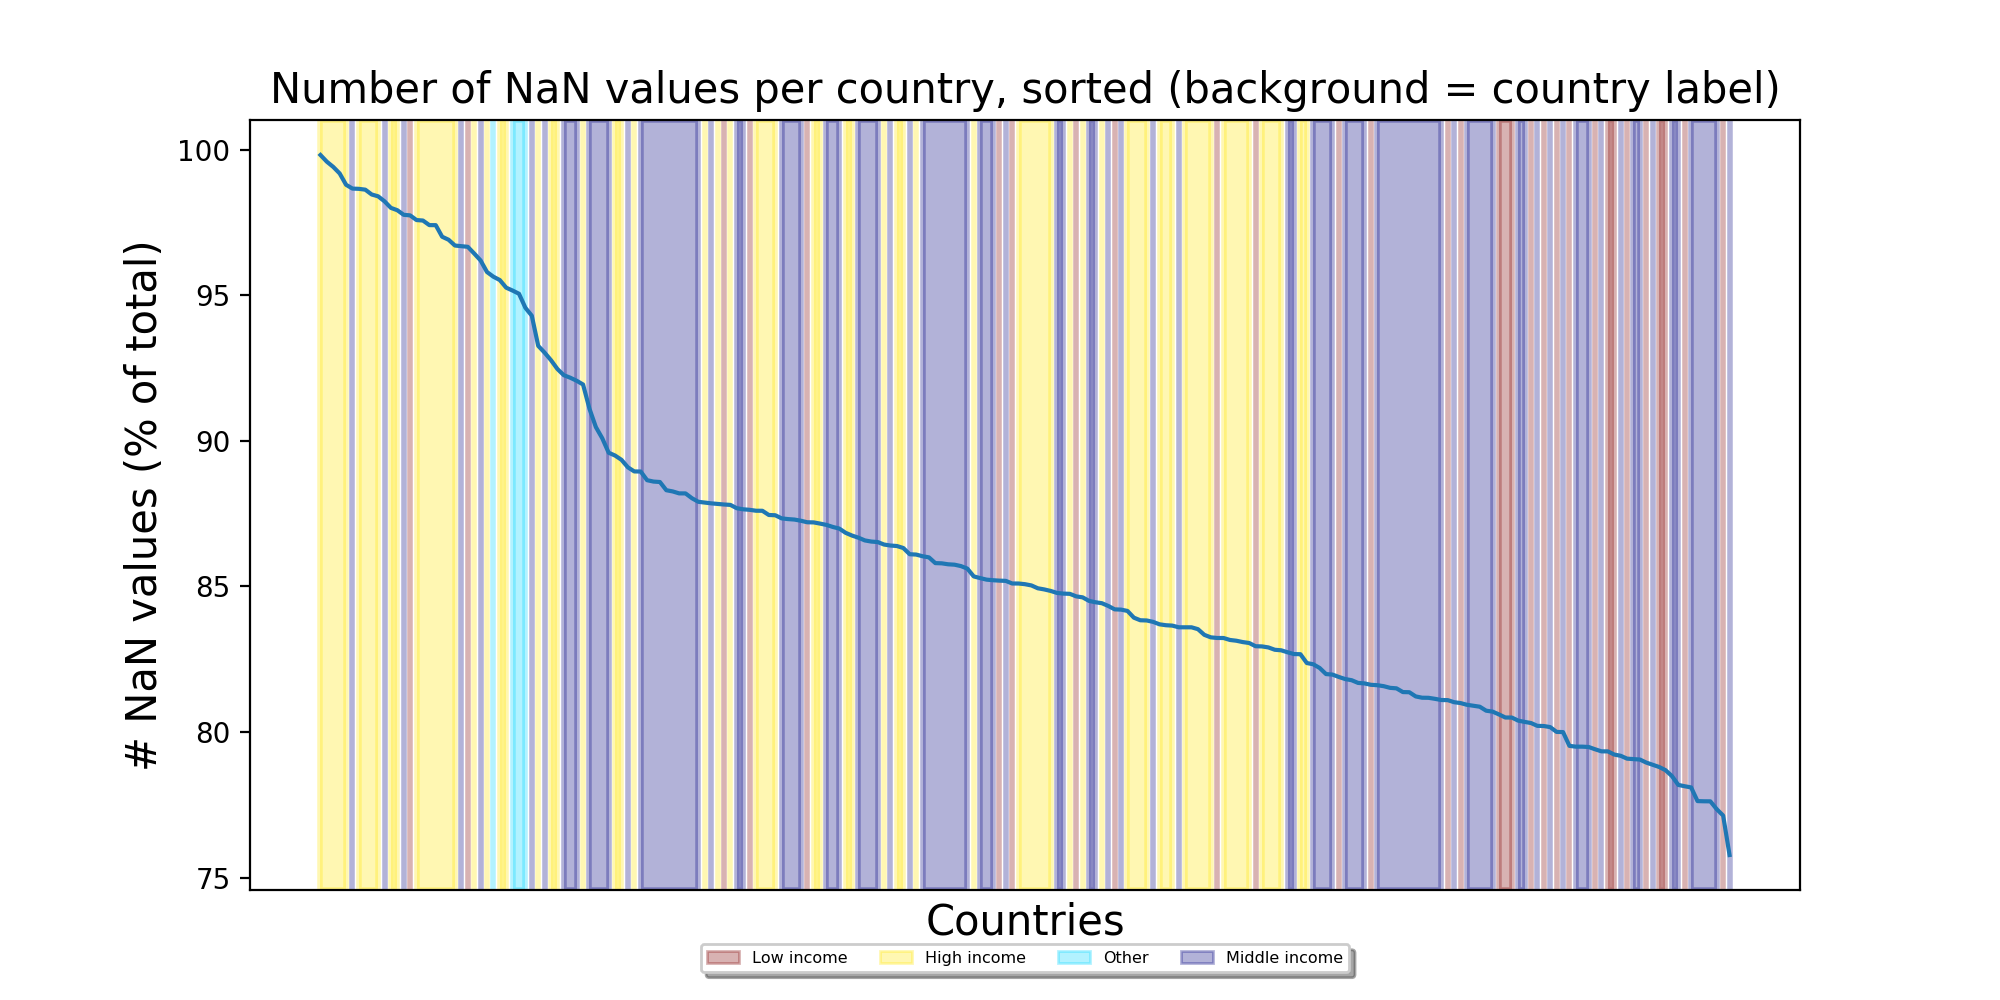

In [8]:
# PLOT NUMBER OF NANS PER COUNTRY, with background color as country's label
plotNANpercountry(data,get_labels(countries,method='incomeLevel')[0])

Interestingly, there seems to be a trend between income level and amount of data available. As one of the goals of the World Bank is "reduction of poverty", it makes sense that most of the data will come from developing countries. 

<IPython.core.display.Javascript object>


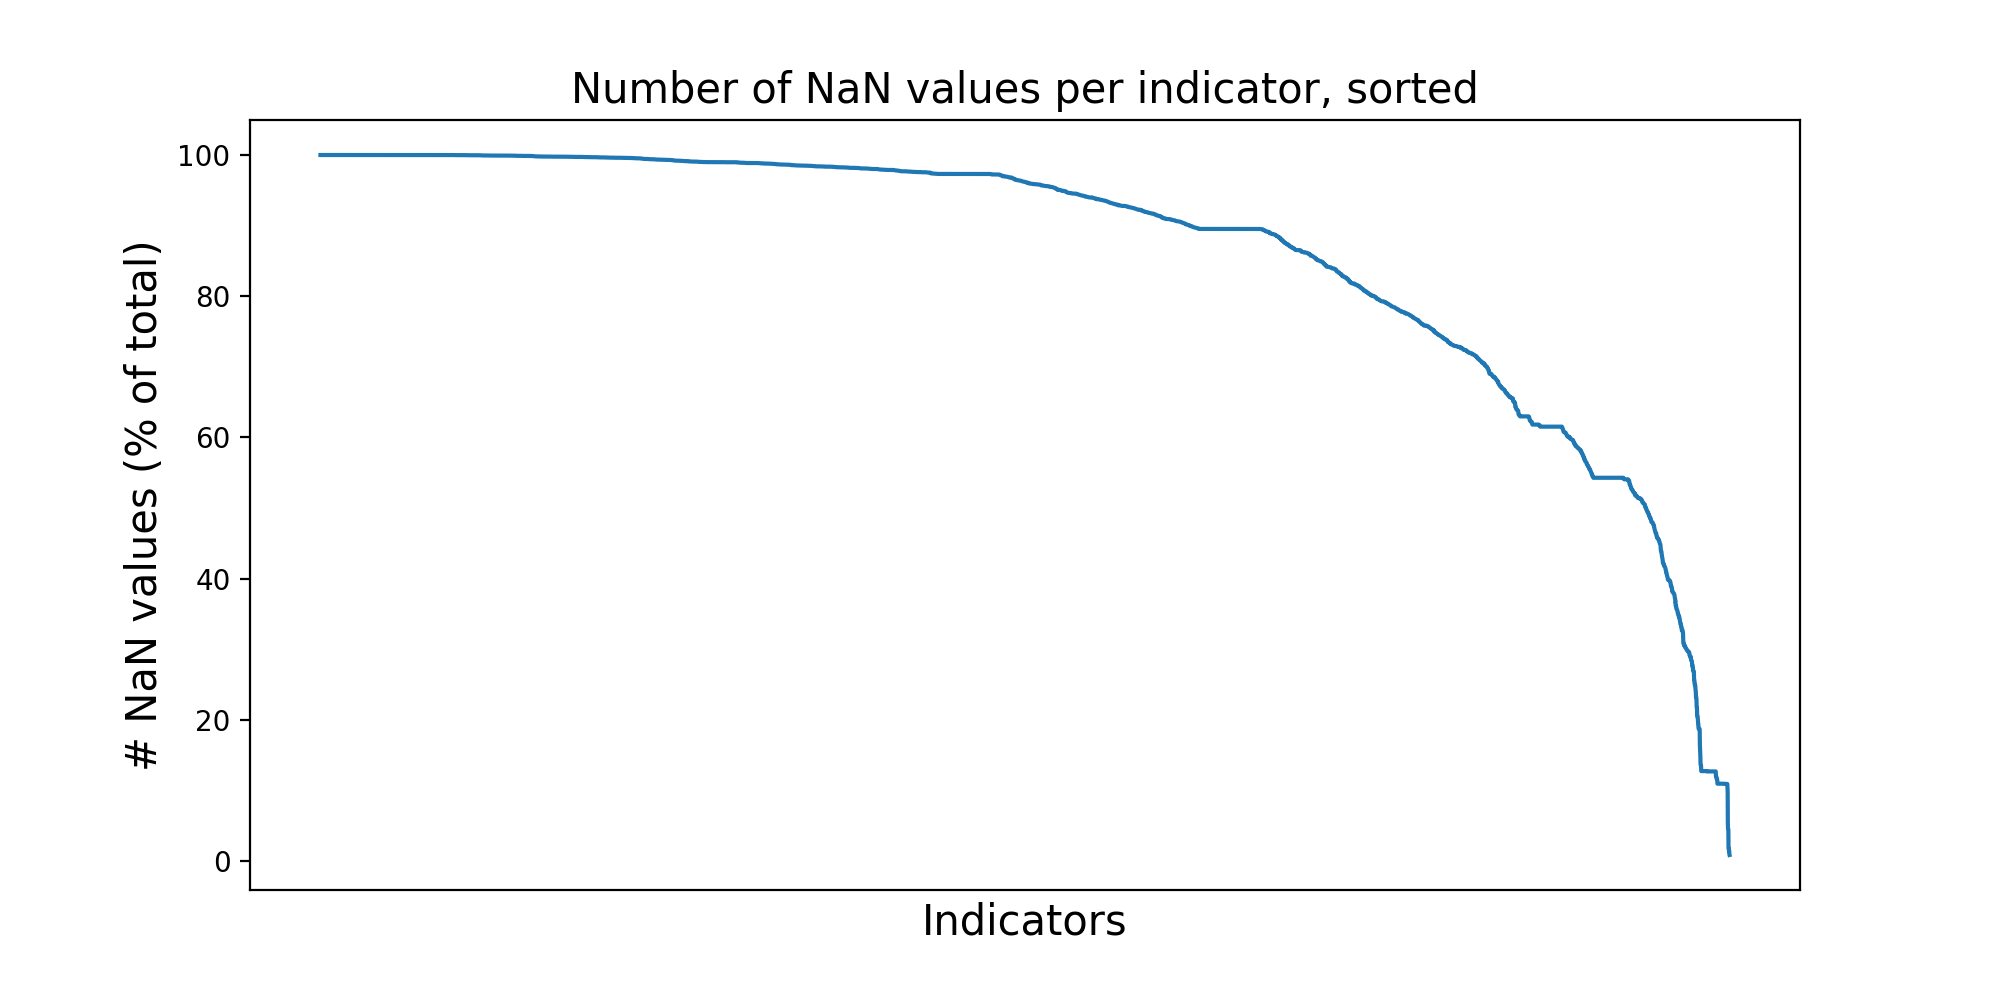

In [9]:
# PLOT NUMBER OF NANS PER INDICATOR, sorted
plotNANperindicator(data,background=False)

As we have seen here, our dataset is very sparse. A lot of data is not actually available.
Several reasons can explain the sparsity of the data.

1. Not all of the indicators were present in 1960. Some were added afterwards and are thus only available since they were added
2. A lot of indicators are not sampled every year. The data comes indeed from surveys that are made every few years as we have seen in the graph about the number of actual data per year.
3. According to the state of the country, not all data could be reported every year. Some countries that are at war, or do not have any official agency for recovering data would of course not appear in the dataset.

## II.a) Cleaning the data

Regarding the proportion of NaN values in our dataset over accross all the years from 1960 to 2015, we determined some strategies in order to get a functional dataset, keeping a time-dimension and the maximum number of countries. 
The first strategy was to make a 3 years-average of the data (cf. __group_data__ function). In this way, we aim at reducing the number of NaN values, while keeping the time evolution of the variables. The dataset has values for some 3 years-period slices from 1960 to 2015 (i.e '1960-1962', '1963-1965',...,'2011-2013'). 

In [10]:
aggregated_data = group_data(data,3,clean=None,what=None) #returns a dictionary containing averaged data (keys= periods, value=corresponding dataset)
print('After averaging the dataset over three years periods, we end up with {} ''slices'' of data from 1960 to 2015'.format(len(aggregated_data)))

A Jupyter Widget


After averaging the dataset over three years periods, we end up with 18 slices of data from 1960 to 2015


However, the number of NaN values was still significant, so another strategy consisted in deleting the columns (indicators) and the rows (countries), one after the other, containing the maximum number of NaN, seeking to maximize the number of countries. (c.f. function __cleaNaN__). 

In [ ]:
"""/!\ Execution of this cell takes long time (cleanNaN over all the periods)"""
agg_data = dict()
for key, value in aggregated_data.items():
    agg_data[key]=cleanNaN(aggregated_data[key])
    
# To save the data averaged by three years (dictionary)
with open('./agg_data.pickle', 'wb') as handle:
    pickle.dump(agg_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
#Open the sliced data
with open('./agg_data.pickle', 'rb') as handle:
    agg_data = pickle.load(handle)

In [12]:
print('The final dataset are of the following shape:')
for key, value in agg_data.items():
    print('period: {}, {} countries and {} indicators'.format(key, len(agg_data[key].index), len(agg_data[key].columns)))

The final dataset are of the following shape:
period: 1960-1962, 145 countries and 183 indicators
period: 1963-1965, 148 countries and 172 indicators
period: 1966-1968, 146 countries and 178 indicators
period: 1969-1971, 161 countries and 211 indicators
period: 1972-1974, 152 countries and 216 indicators
period: 1975-1977, 159 countries and 205 indicators
period: 1978-1980, 156 countries and 219 indicators
period: 1981-1983, 154 countries and 222 indicators
period: 1984-1986, 159 countries and 223 indicators
period: 1987-1989, 157 countries and 224 indicators
period: 1990-1992, 157 countries and 490 indicators
period: 1993-1995, 158 countries and 455 indicators
period: 1996-1998, 157 countries and 509 indicators
period: 1999-2001, 155 countries and 602 indicators
period: 2002-2004, 158 countries and 604 indicators
period: 2005-2007, 155 countries and 620 indicators
period: 2008-2010, 156 countries and 632 indicators
period: 2011-2013, 157 countries and 645 indicators


## II.c) Exploring the data

### *Checking some intuitive correlation*

We tried to check here some indicators that should _a priori_ be correlated. We could indeed confirm in the first plots that several indicators were correlated and we had nice clusters according to the income level. 

In the last plot however, the intuitive correlation was not confirmed. Even though the data was normalized, several outliers are visible and could probably have biased the data. 

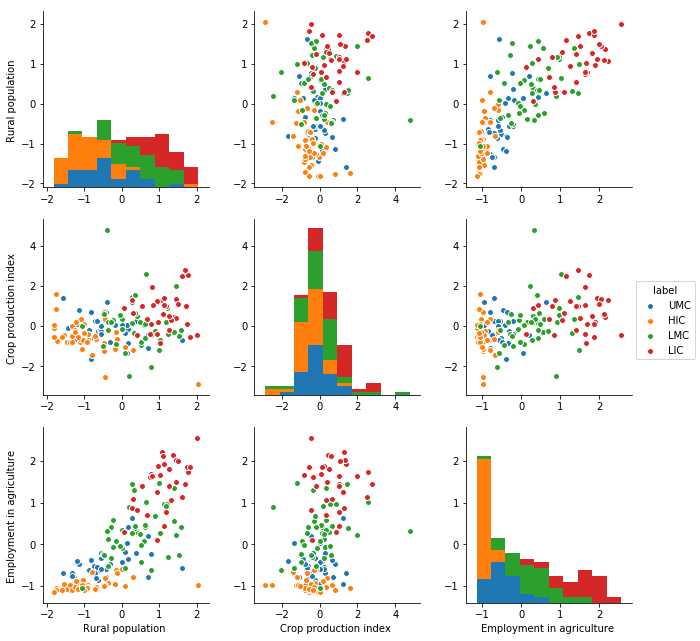

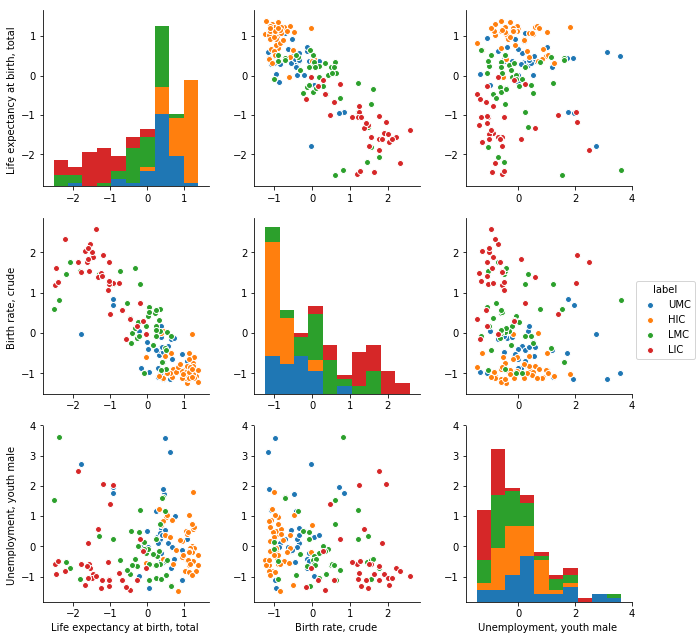

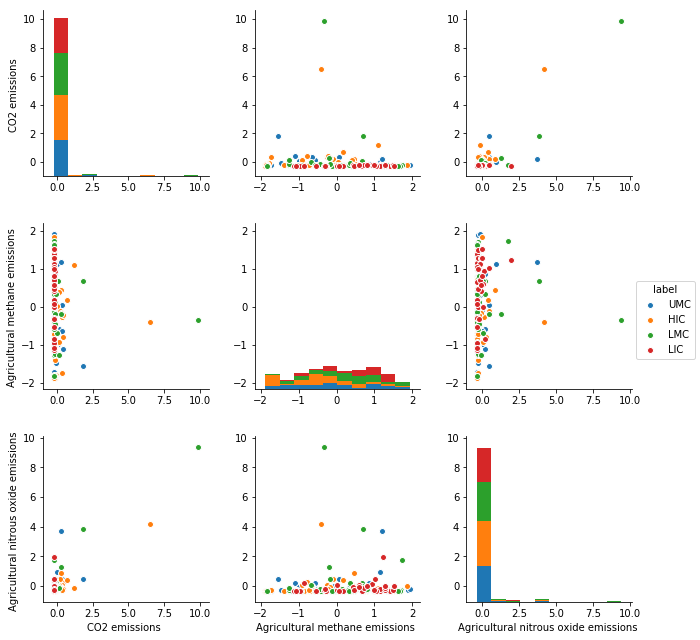

In [13]:
key='2008-2010' 
var1='Rural population (% of total population)'
var2='Crop production index (2004-2006 = 100)'
var3='Employment in agriculture (% of total employment) (modeled ILO estimate)'
var4='Life expectancy at birth, total (years)'
var5='Birth rate, crude (per 1,000 people)'
var6='Unemployment, youth male (% of male labor force ages 15-24) (modeled ILO estimate)'

var7='CO2 emissions (kt)'
var8='Agricultural methane emissions (% of total)'
var9='Agricultural nitrous oxide emissions (thousand metric tons of CO2 equivalent)'

variables_total=dict()
variables_total[0] = [var1,var2,var3]
variables_total[1] = [var4,var5,var6]
variables_total[2] = [var7,var8,var9]
%matplotlib inline
for i in range(0,len(variables_total.keys())):
    
    code_indicators=agg_data[key].columns.values
    df=agg_data[key]
    all_variables=converter(code_indicators,code_to_indicator)
    variables=variables_total[i]
    var_codes=converter_reverse(variables, code_to_indicator)

    df=df[var_codes]
    df -= np.nanmean(df,axis=0)
    df/= np.nanstd(df,axis=0)
    df.columns = [code_to_indicator[df.columns[0]].split('(')[0],code_to_indicator[df.columns[1]].split('(')[0],\
                  code_to_indicator[df.columns[2]].split('(')[0]]

    vec=[]
    for i in df.index:
        vec.append(labels['2009'][i])
    df2=df.assign(label=vec)
    
    sns.pairplot(df2, hue="label",size=3);

After checking the different indicators left, we decided to study the data from a thematic point of view. The different themes we chose (according to indicators available were the following:<br>
1. demographic <br>
2. education<br>
3. health <br>
4. social <br>
5. economic <br>
6. gas production <br>
7. technology.<br>
8. political unstability

To do so, we attributeed the indicators to the different theme lists thanks to the __theme_selector__ function that retrieves indicators by key words related to the theme. 

In [14]:
#key words list
demographic_kw=['birth','expectancy','ages','rural','urban']
education_kw=['school','literacy','teacher','education']
health_kw=['water','defecation','sanitation', 'anemia','immunization','hiv','contraceptive','health','tetanus',\
           'malnutrition','smoking','tuberculosis','lifetime','death','fertility','risk','obesity','overweight',\
           'survival']
social_kw=['labor','employment','unemployment','corruption','workers','wage']
economic_kw=['economic','debt','GDP','merchandise','goods','banking','wage']
gas_production_kw=['CO2','fuel','energy','methane','nitrous','mineral']
technology_kw=['telephone','cellular','electricity']
unstability_kw=['Violence/Terrorism']

########################################
theme_dico={'demographic':demographic_kw,'education': education_kw,'health':health_kw,'social':social_kw,\
       'economic':economic_kw,'gas_production':gas_production_kw,'technology':technology_kw}

#Creation of the 2 dimensions-dictionary (1: periods, 2:themes)
agg_theme_data=dict.fromkeys(agg_data.keys())
for key, value in agg_theme_data.items():
    agg_theme_data[key]=defaultdict(dict).fromkeys(theme_dico.keys())

for key1, value1 in agg_data.items():
    for key2, value2 in theme_dico.items():
    # Theme list creation
        code_indicators=agg_data[key1].columns.values
        """preparation of the thematic dataset according to the theme"""
        theme_list, theme_name = make_theme_list (key2, theme_dico[key2], code_to_indicator,code_indicators)
        theme_code=converter_reverse(theme_list, code_to_indicator)
        theme_code2=list(theme_code)
        for i in theme_code2:
            if i not in agg_data[key1].columns.values:
                theme_code.remove(i)

        agg_theme_data[key1][key2]=agg_data[key1][theme_code]

The pipeline of our exploratory phase is to create similarity graphs. The countries are the nodes. The edges represent the strength of similarity between two nodes for a given theme (e.g education, health etc..).<br>
In the next cell, we show the pipeline for one given case: gas_production in '2008-2010' for level income grouping of countries. 


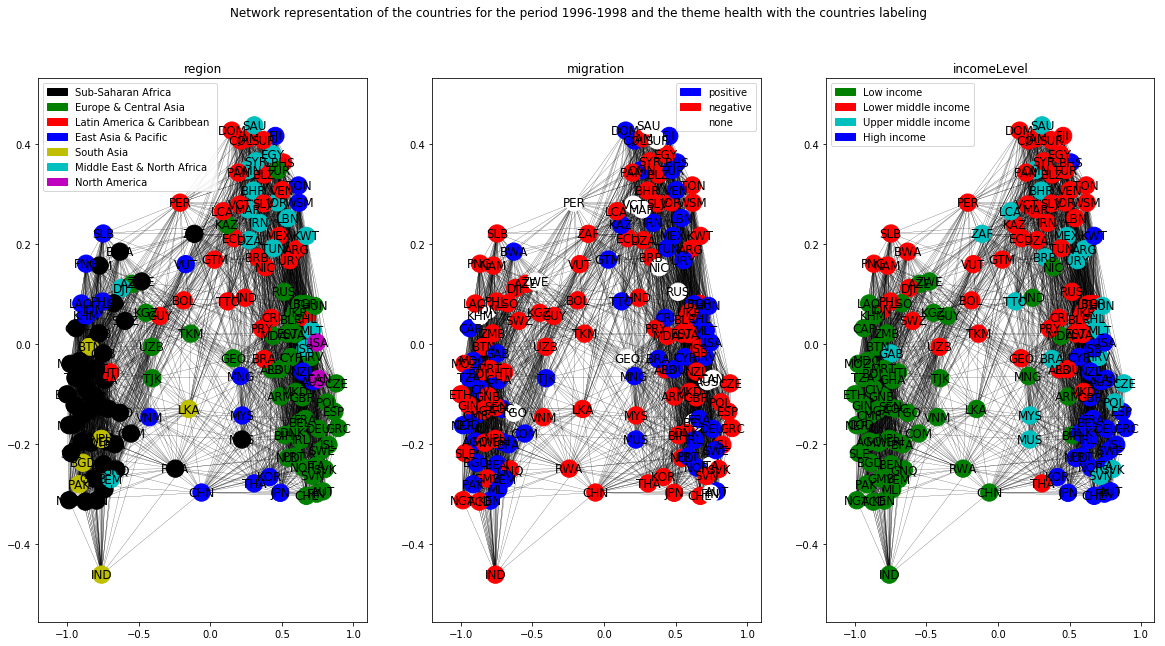

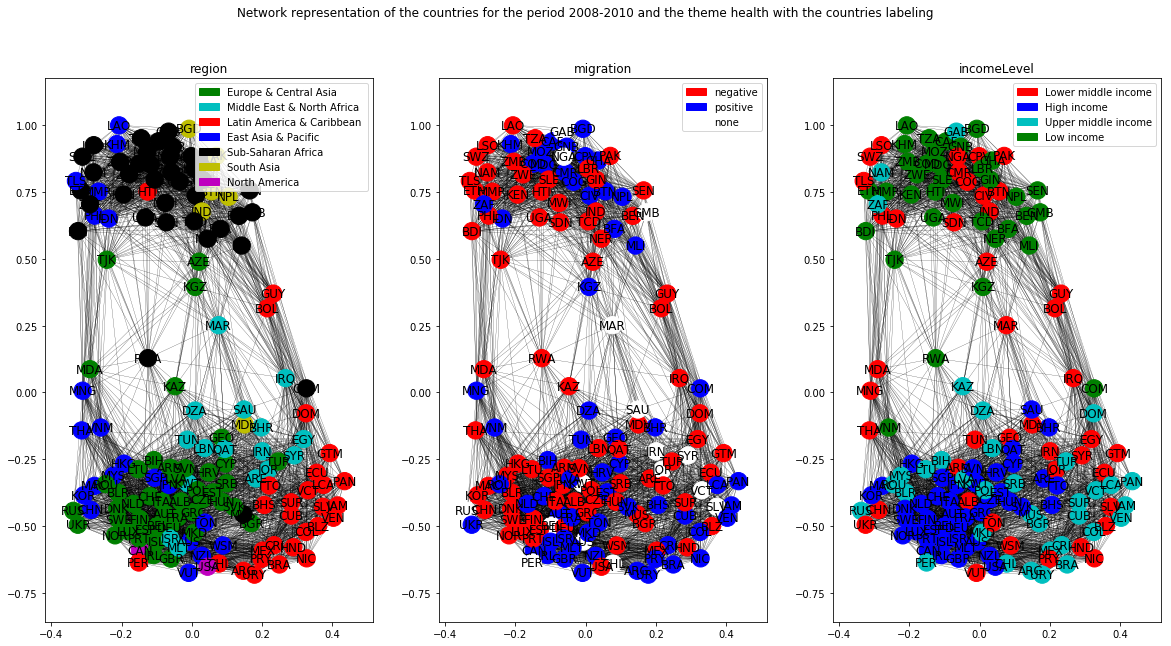

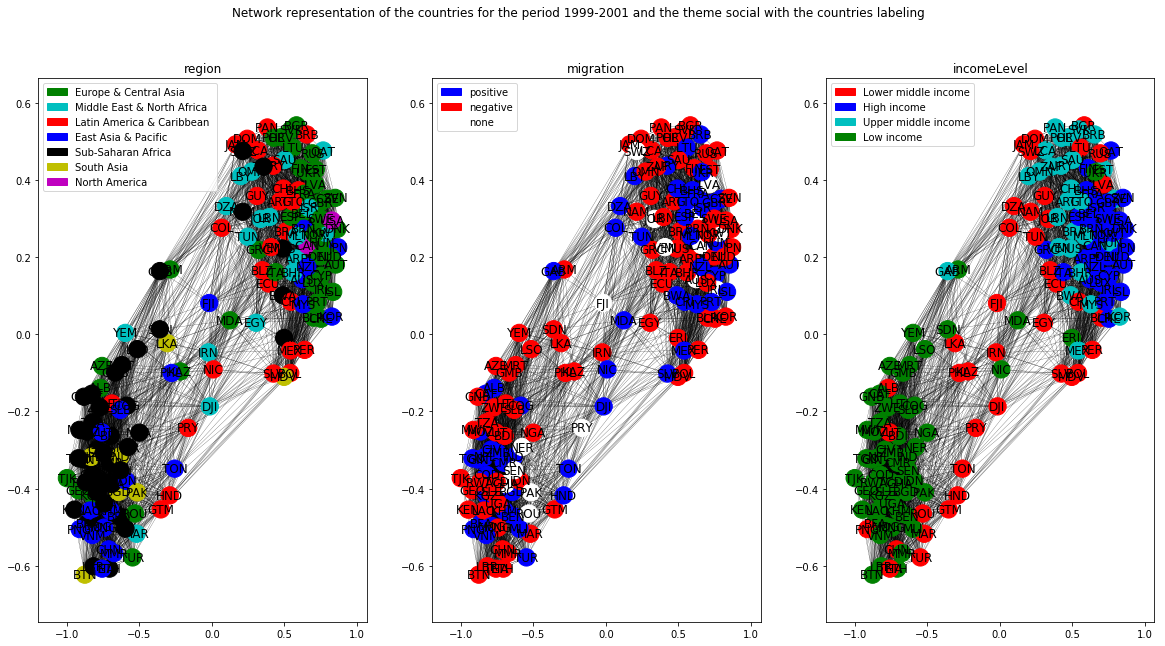

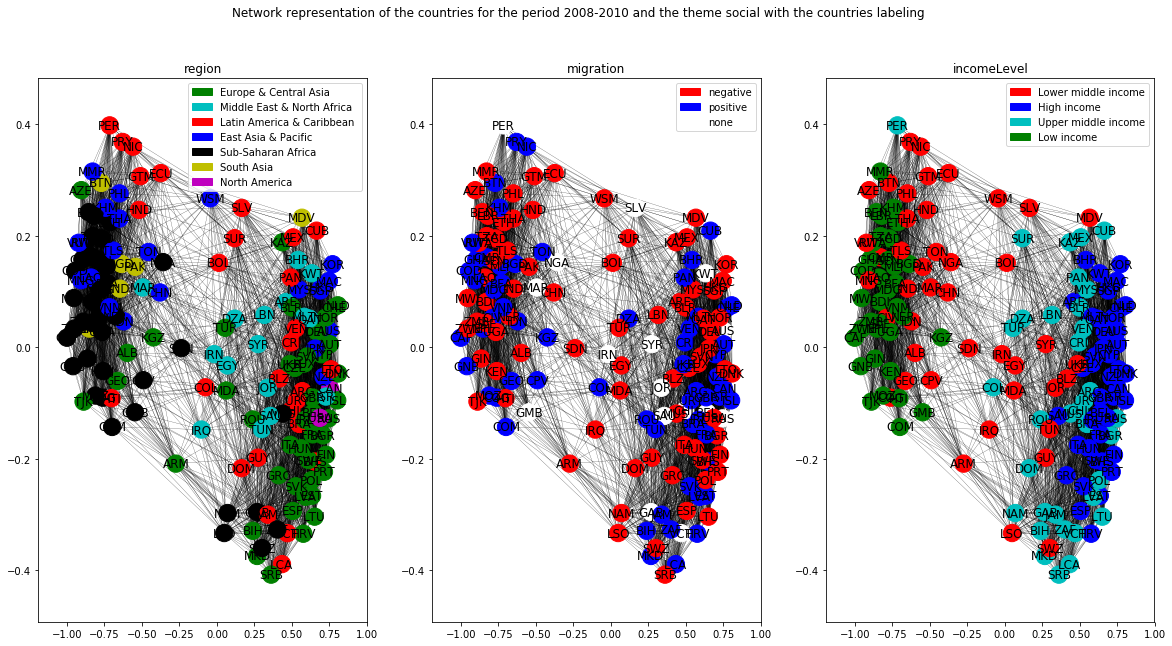

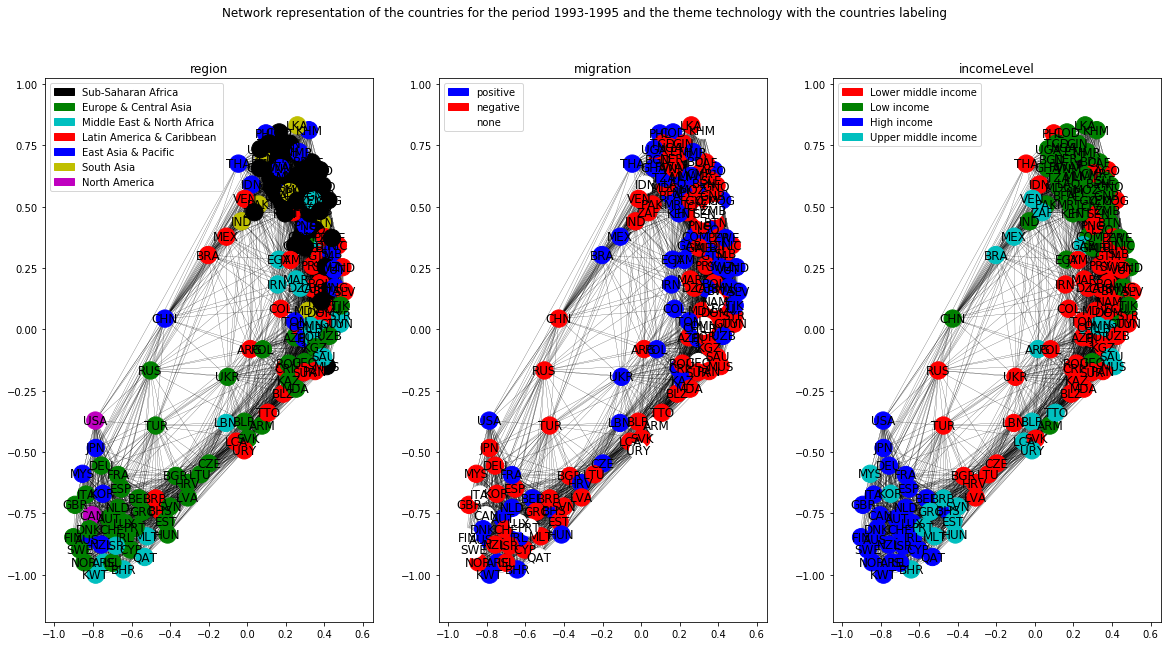

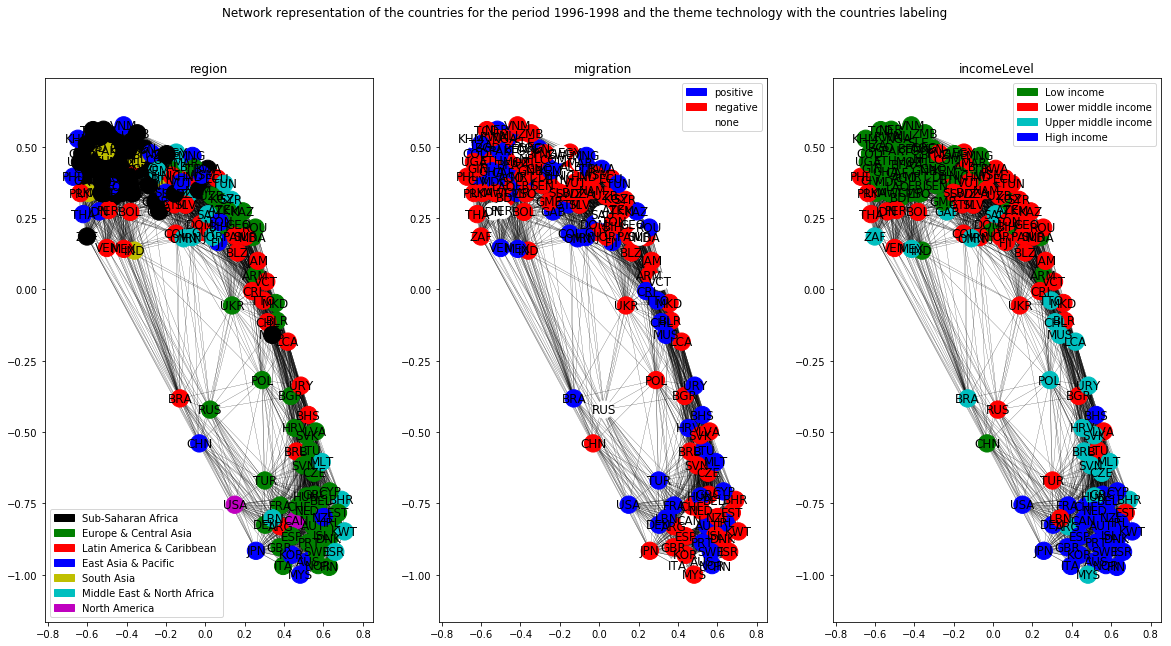

In [15]:
network_plot(agg_theme_data, period='1996-1998', theme='health', sparse='NN', neigh=40,data=data)
network_plot(agg_theme_data, period='2008-2010', theme='health', sparse='NN', neigh=40,data=data)

network_plot(agg_theme_data, period='1999-2001', theme='social', sparse='NN', neigh=40,data=data)
network_plot(agg_theme_data, period='2008-2010', theme='social', sparse='NN', neigh=40,data=data)

network_plot(agg_theme_data, period='1993-1995', theme='technology', sparse='NN', neigh=40,data=data)
network_plot(agg_theme_data, period='1996-1998', theme='technology', sparse='NN', neigh=40,data=data)

In [19]:
from IPython.display import Javascript, display, HTML
display(HTML(open("./Visualization/draw_network.html", "r").read()))

"""/!!\ THIS DYNAMIC VISUALIZATION DOES NOT WORK HERE --> SEE IN FOLDER VISUALIZATION """

'/!!\\ THIS DYNAMIC VISUALIZATION DOES NOT WORK HERE --> SEE IN FOLDER VISUALIZATION '

## Dimensionality reduction

we want to see how separable is our data depending on each thematic feature with PCA.

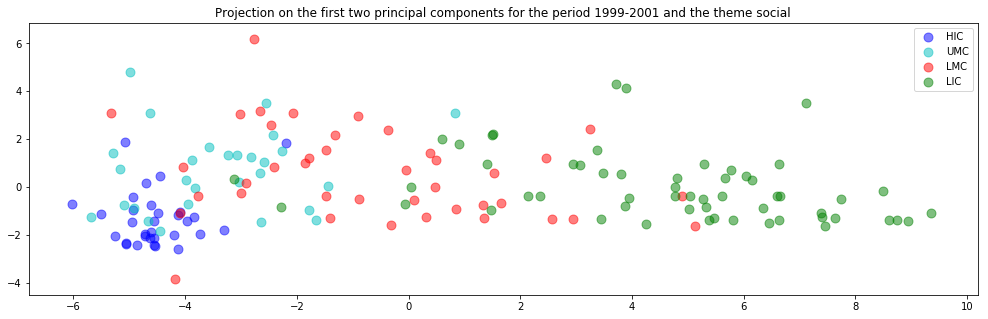

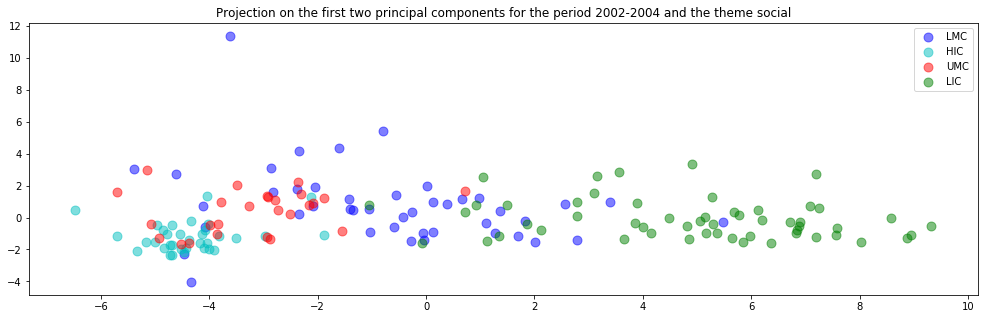

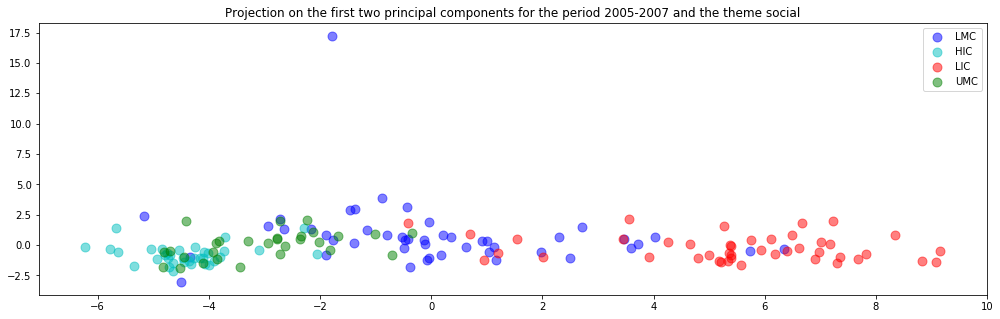

In [16]:
# PCA VISUALIZATION
pca_plot(agg_theme_data, period='1999-2001', theme='social', methode='incomeLevel')
pca_plot(agg_theme_data, period='2002-2004', theme='social', methode='incomeLevel')
pca_plot(agg_theme_data, period='2005-2007', theme='social', methode='incomeLevel')

Another step in the exploration consisted in checking how separable is the data with Principal Component Analysis method. The plots represent the projection of the data corresponding to the theme 'social' on the two first components. (for 3 different periods). In the first plot, the data is nicely distinguishable in term of the income level. Indeed, the color of the labels smoothly change when moving along the x-axis (PC1). When going through the years, we can see that the data almost only project on the first PC. It means that the second PC does not provide anymore information about variance of the data. 
Only the 'social' features resulted in a good separable data with PCA.

# II. Data Exploitation

From the exploration part, we could see that the migration categorization was not relevant, and could not correlate with any variables. However, the drawing of similarity networks showed a good clusterization in term of regions and income level categories. 

In this part, we would like to show if we can infer the classes of income level from the information carried through the different thematic features.

## II.a) Spectral graph analysis

The next step in the project was to see if we could infer the situation of the countries in term of income level, depending on the different features, categorized by theme. 
To do so, we first embedded the graph, by projecting the data on the second and third eigenvectors.

For the period 1996-1998 and the theme health, we have 71 errors (45.22%)


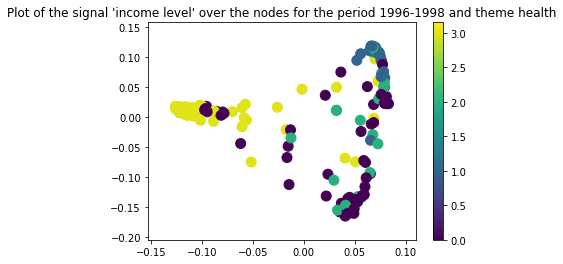

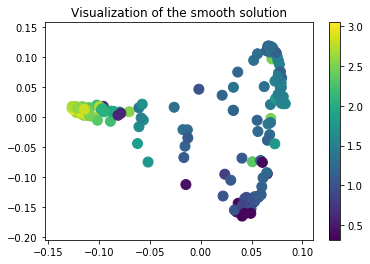

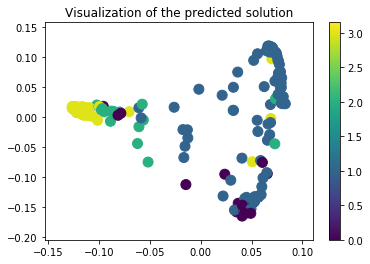

For the period 2005-2007 and the theme social, we have 65 errors (41.94%)


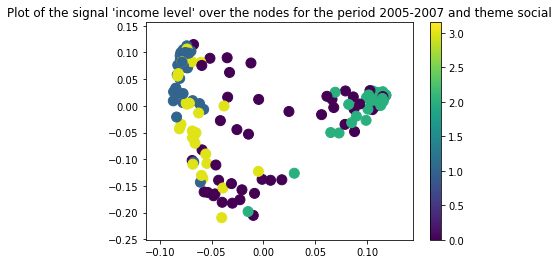

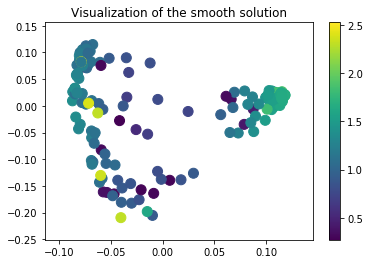

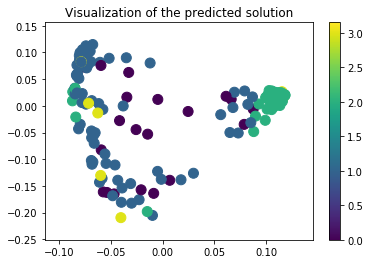

For the period 2008-2010 and the theme social, we have 45 errors (28.85%)


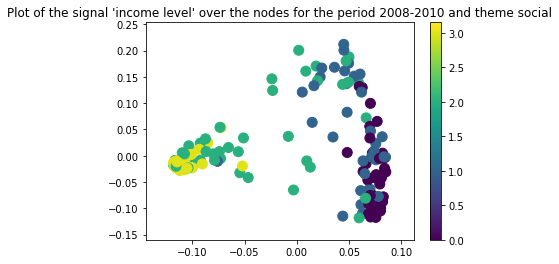

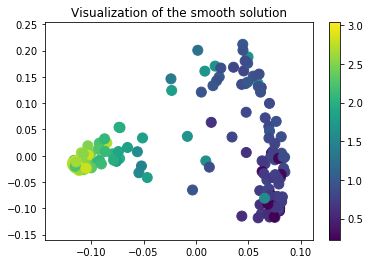

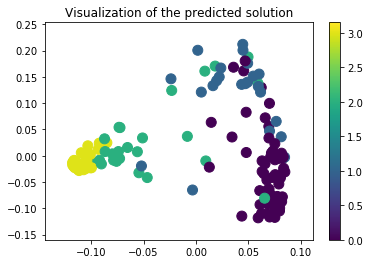

For the period 1993-1995 and the theme technology, we have 46 errors (29.11%)


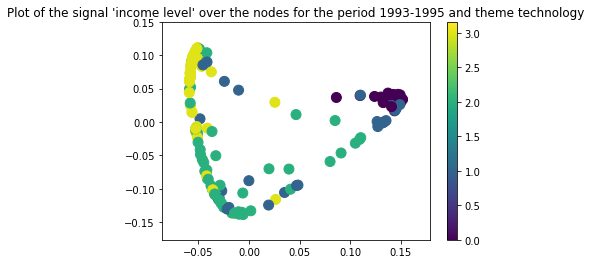

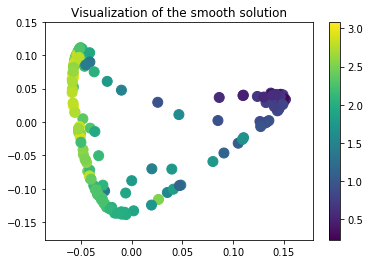

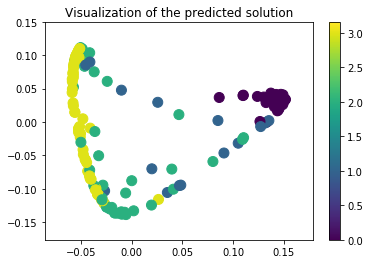

In [17]:
%matplotlib inline
plotting.BACKEND = 'matplotlib'
plot_spectral(agg_theme_data, period='1996-1998', theme='health', methode='incomeLevel')
plot_spectral(agg_theme_data, period='2005-2007', theme='social', methode='incomeLevel')
plot_spectral(agg_theme_data, period='2008-2010', theme='social', methode='incomeLevel')
plot_spectral(agg_theme_data, period='1993-1995', theme='technology', methode='incomeLevel')

In this part we intended to classify the countries into the different categories of income level: low income, lower medium income, higher medium income and high income. To do so, we used an unsupervised learning method. It computes a smooth solution, and we infer from it the predicted solution. In general, the obtained errors are quite high (around 50%) with a hidding proportion of 0.25. However, we noticed that some themes allow a better prediction than other. For example, features related to technology offered a low error of classification, as well as health, or economic features. Those are the same themes that were already giving a well-clustered network in the networks drawings of the exploration part.

We notice that the lowest error is for technology (29%) for the period 1993-1995. Features about technology were found with the key words 'internet', 'mobile', telephone' and 'electricity'. This period is critical and determining to discriminate between the different countries, especially in term of income level. Indeed, this period is when the technology boom happenened in western countries.

# III. Conclusion


We have seen throughout the project that indicators grouped in themes could somehow predict the income level of a country. Classifying the countries by geographical region was however more difficult, and the errors were very large. This can be explained by the fact that we had 7 regions to classify and that some of them had very little countries remaining. 

Some of the themes (demographics, economy, health, social, technology) were better at discriminating between income levels, as opposed to education or gas production.
The fact that 'economy' could nicely predict income levels is pretty intuitive. The income level is defined by GNI per capita and is tightly link to the economical health of a country. 

A limitation of the analysis is that the chosen themes were very broad, and that the themes were not necesarily comparable as not all of them had the same number of indicators. Some of the themes had even more indicators than actual observations, which makes the classification very difficult.